<div style="font-size:40px; color:#0F2080;">
  Imports <span style="color:#F5793A;">
</div>

In [1]:
# Core libraries
import os
import glob
import numpy as np
import scipy
import warnings
from pathlib import Path

# Astropy
from astropy.io import fits
from astropy.io.misc import yaml
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.table import Table
from astropy.visualization import simple_norm

# specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

# pahfit
import pahfit
from pahfit.errors import PAHFITPackError, PAHFITWarning
from pahfit.modelj import Model
#from pahfit.model import Model
from pkg_resources import resource_filename

# pyPAHdb
import pypahdb
from pypahdb.decomposer import Decomposer
from pypahdb.observation import Observation

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib.patches import Rectangle

# tqdm for progress bars
import tqdm

#Pathing
repo_dir = Path().resolve().parent
fits_dir = repo_dir / "3_Hydrocarbons"
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"
polycyclic_dir   = repo_dir / "1_Polycyclic"

# Confirm available FITS files
fits_files = sorted(hydrocarbons_dir.glob("*.fits"))

print(f"Found {len(fits_files)} FITS files in {hydrocarbons_dir}:")
for file in fits_files:
    print(" -", file.name)

Found 55 FITS files in C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons:
 - CH1_ring1.fits
 - CH1_ring2.fits
 - CH1_ring3.fits
 - CH1_ring4.fits
 - CH1_ring5.fits
 - CH1_ring6.fits
 - CH1_ring7.fits
 - CH1_ring8.fits
 - CH2_ring1.fits
 - CH2_ring2.fits
 - CH2_ring3.fits
 - CH2_ring4.fits
 - CH2_ring5.fits
 - CH2_ring6.fits
 - CH2_ring7.fits
 - CH2_ring8.fits
 - CH3_ring1.fits
 - CH3_ring2.fits
 - CH3_ring3.fits
 - CH3_ring4.fits
 - CH3_ring5.fits
 - CH3_ring6.fits
 - CH3_ring7.fits
 - CH3_ring8.fits
 - jw01328-c1006_t014_miri_ch1-shortmediumlong_s3d.fits
 - jw01328-c1006_t014_miri_ch1-shortmediumlong_x1d.fits
 - jw01328-c1006_t014_miri_ch2-shortmediumlong_s3d.fits
 - jw01328-c1006_t014_miri_ch2-shortmediumlong_x1d.fits
 - jw01328-c1006_t014_miri_ch3-shortmediumlong_s3d.fits
 - jw01328-c1006_t014_miri_ch3-shortmediumlong_x1d.fits
 - NGC7469__stitched.fits
 - Ring1_1dspec.fits
 - Ring1_pahonly.fits
 - Ring1_stitched.fits
 - Ring2_1dspec.fits
 - Ring2_pahonly.fits
 - Ring2_stitched

C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Ajuste completado y guardado en: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4_pahfit.ecsv


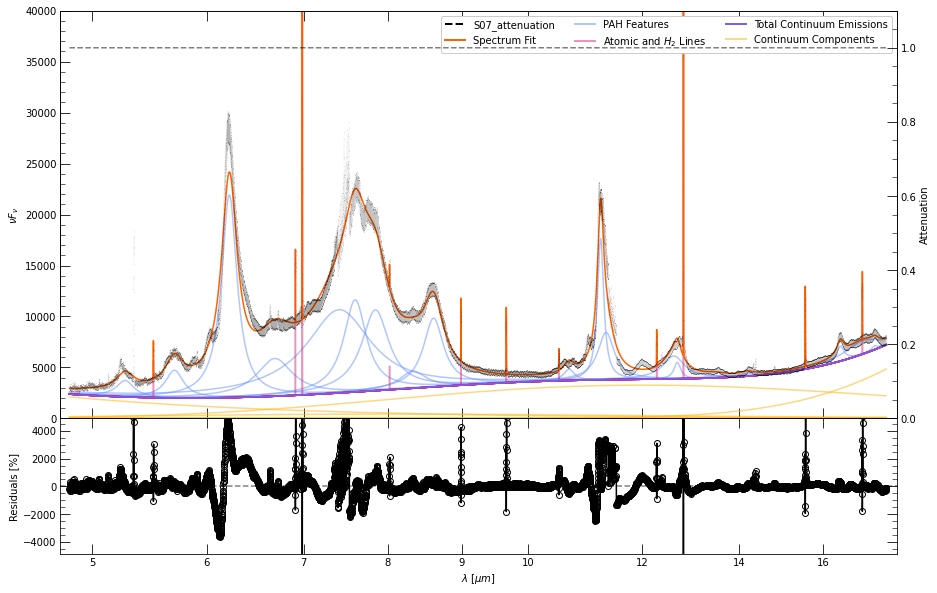

In [2]:
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model

# === 1. Leer tabla desde el archivo FITS ===
fits_file = hydrocarbons_dir / "Ring8_1dspec.fits"
table = Table.read(fits_file, hdu=1)

# === 2. Convertir columnas a Quantity con unidades adecuadas ===
wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)

# === 3. Incertidumbre dummy (5% del flujo) ===
errors = StdDevUncertainty(0.05 * fluxes)

# === 4. Crear objeto Spectrum1D ===
spec = Spectrum1D(
    spectral_axis=wavelengths,
    flux=fluxes,
    uncertainty=errors
)

# === 5. Metadata y redshift ===
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# === 6. Ajuste con PAHFIT ===
model = Model.from_yaml('classic.yaml')
model.features.meta["user_unit"]["flux"] = fluxes.unit  # evita crash en .guess()

model.guess(spec)
model.fit(spec)
model.plot(spec)

# === 7. Guardar resultados ===
output_file = polycyclic_dir / "Ring4_pahfit.ecsv"
model.save(str(output_file), overwrite=True)
print(f"[PAHFIT] Ajuste completado y guardado en: {output_file}")

<div style="font-size:40px; color:#0F2080;">
  Running <span style="color:#F5793A;">PAHfit</span> 
</div>

C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Fitting completed and results saved to: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\NGC7469.ecsv


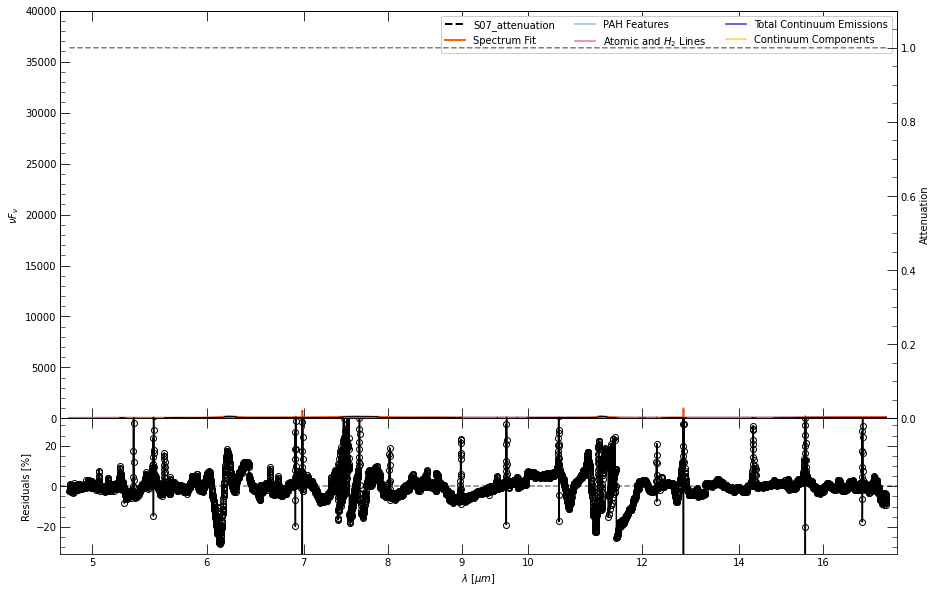

In [3]:
warnings.filterwarnings("ignore", category=PAHFITWarning)

# Load the stitched spectrum
fits_file = hydrocarbons_dir / "NGC7469__stitched.fits"
spec = Spectrum1D.read(str(fits_file))

# Metadata and redshift
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# Load model, fit, plot, and save
model = Model.from_yaml('classic.yaml')
model.guess(spec)
model.fit(spec)
model.plot(spec)

# Save
output_file = polycyclic_dir / "NGC7469.ecsv"
model.save(str(output_file), overwrite=True)
print("Fitting completed and results saved to:", output_file)

C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Ring 1 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring1_pahfit.ecsv


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Ring 2 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring2_pahfit.ecsv


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Ring 3 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring3_pahfit.ecsv


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[PAHFIT] Ring 4 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4_pahfit.ecsv


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Ring 5 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring5_pahfit.ecsv


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Ring 6 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring6_pahfit.ecsv


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Ring 7 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring7_pahfit.ecsv


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Ring 8 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring8_pahfit.ecsv


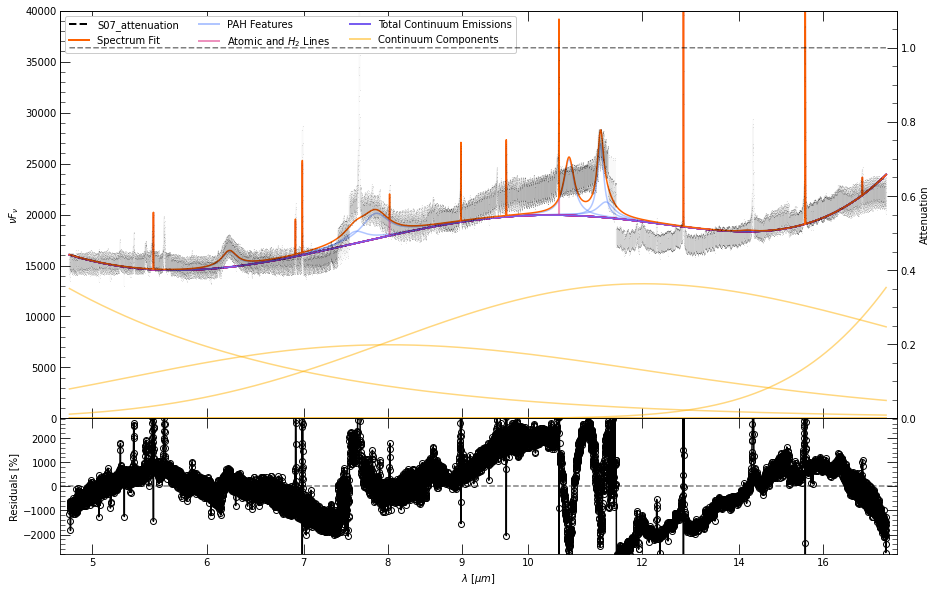

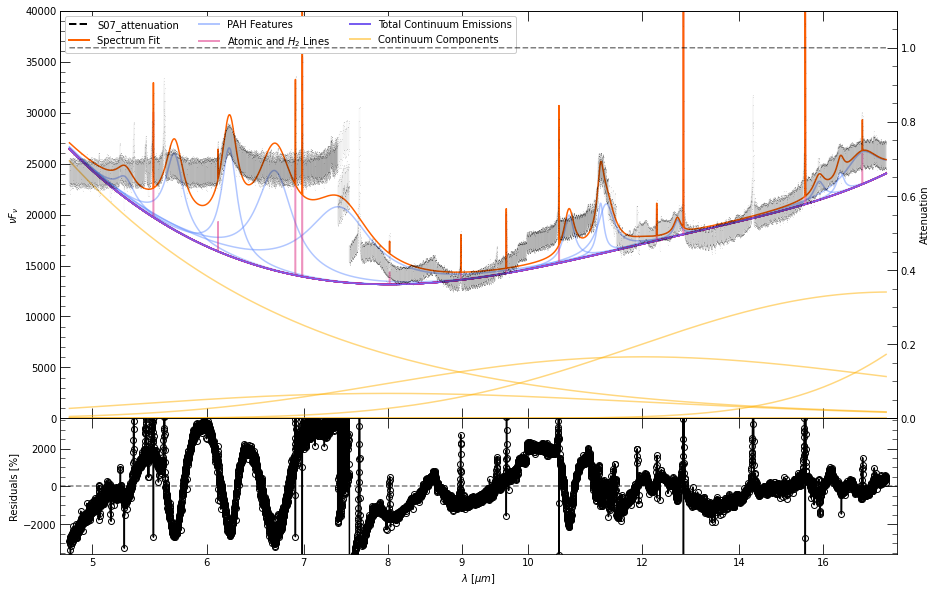

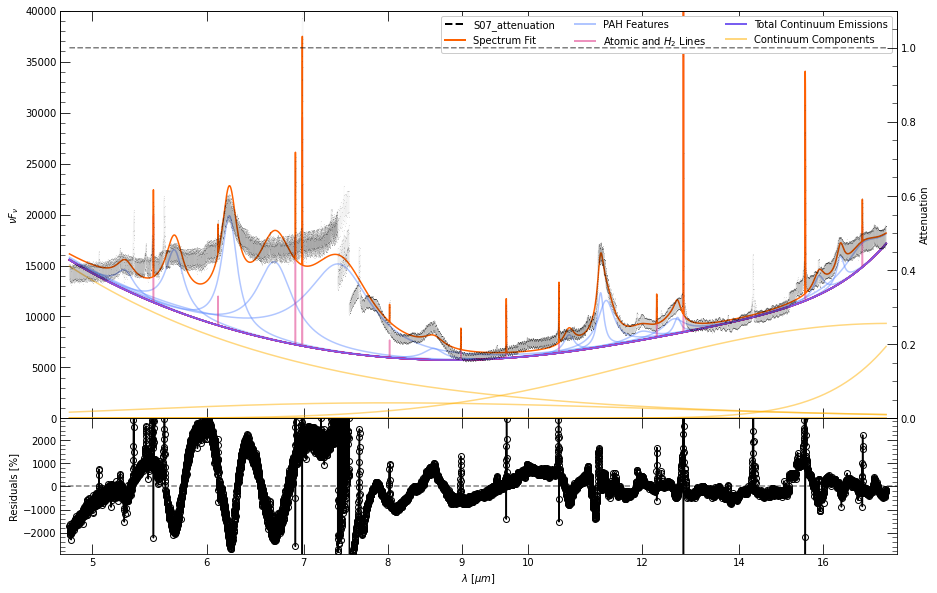

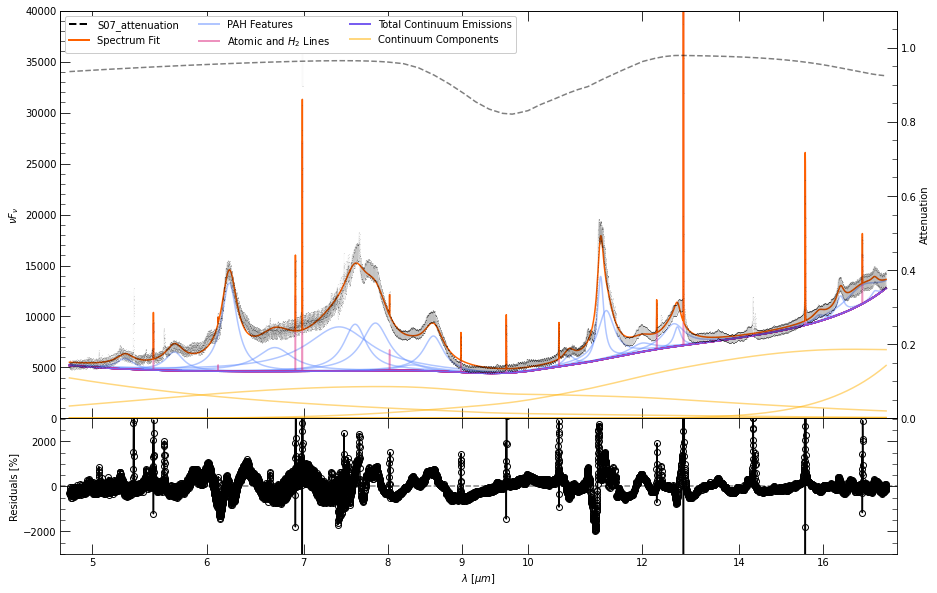

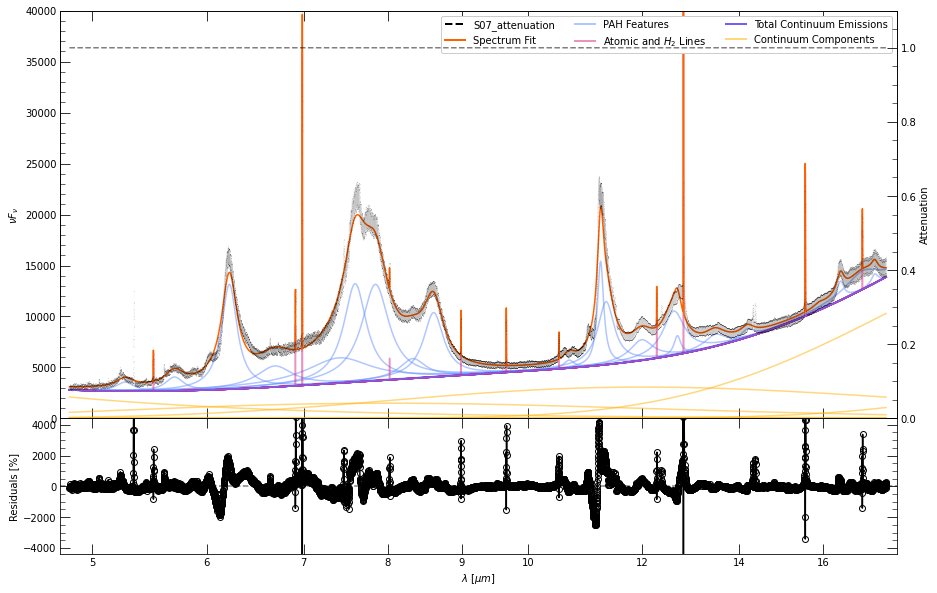

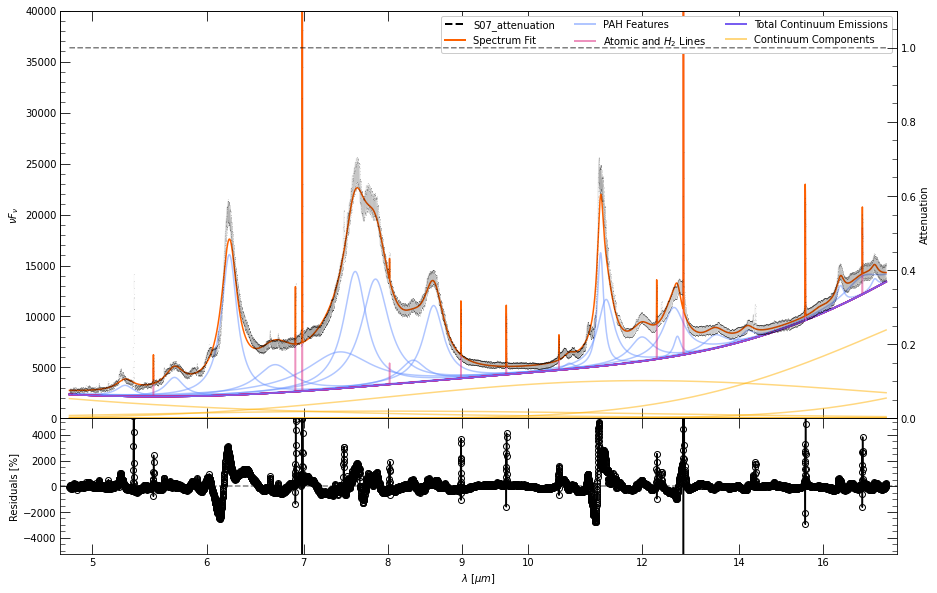

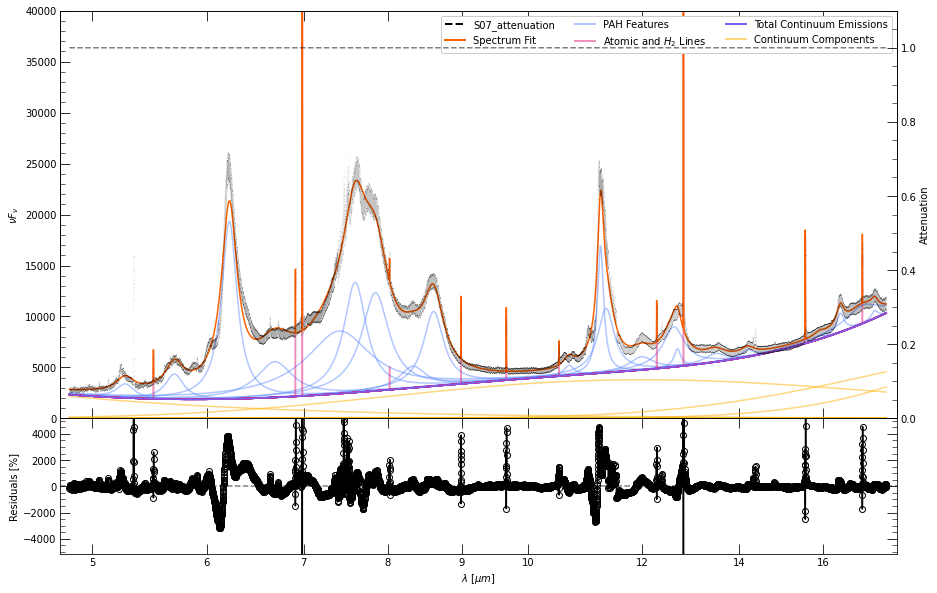

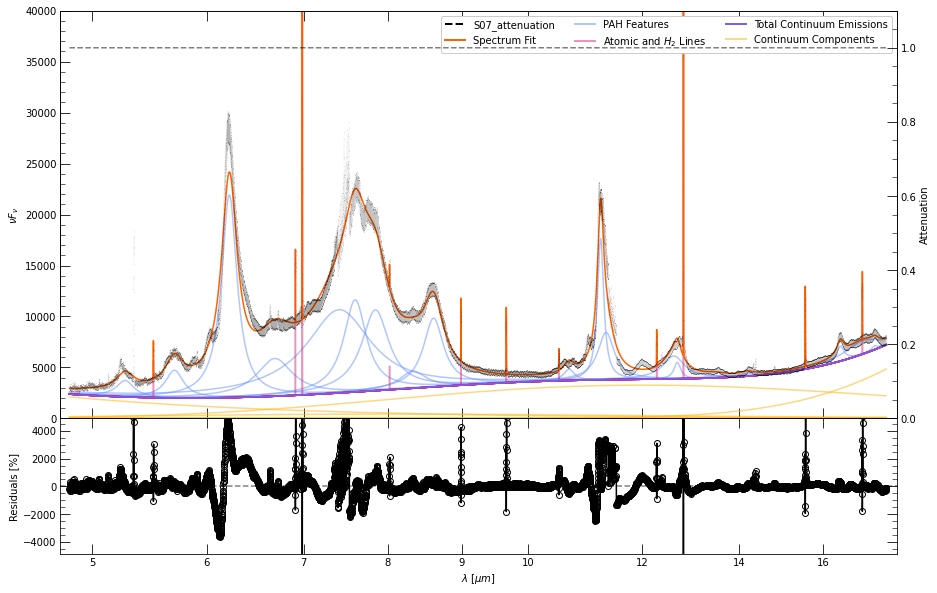

In [4]:
from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import astropy.units as u

for i in range(1, 9):
    fits_file = hydrocarbons_dir / f"Ring{i}_1dspec.fits"
    output_file = polycyclic_dir / f"Ring{i}_pahfit.ecsv"
    if not fits_file.exists():
        print(f"[SKIP] Not found: {fits_file}")
        continue

    table = Table.read(fits_file, hdu=1)
    wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
    fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)
    errors = StdDevUncertainty(0.05 * fluxes)

    spec = Spectrum1D(spectral_axis=wavelengths, flux=fluxes, uncertainty=errors)
    spec.meta['instrument'] = 'jwst.miri.*.*'
    spec.set_redshift_to(0.016268)

    model = Model.from_yaml('classic.yaml')
    model.features.meta["user_unit"]["flux"] = fluxes.unit
    model.guess(spec)
    model.fit(spec)
    fig = model.plot(spec)
    if fig is not None:
        fig.savefig(plot_file)
    model.save(str(output_file), overwrite=True)
    print(f"[PAHFIT] Ring {i} completed: {output_file}")


In [5]:
import numpy as np
from astropy.table import Table
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty
from pahfit.modelj import Model
import astropy.units as u

repo_dir = Path().resolve().parent
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

for i in range(1, 9):  # Change range as needed
    fits_file = hydrocarbons_dir / f"Ring{i}_1dspec.fits"
    table = Table.read(fits_file, hdu=1)
    wavelength = table['wavelength']
    flux = table['flux']

    # Make sure both are astropy Quantities
    wavelength = u.Quantity(wavelength, unit=wavelength.unit)
    flux = u.Quantity(flux, unit=flux.unit)

    # Create spectrum object
    spec = Spectrum1D(
        spectral_axis=wavelength,
        flux=flux,
        uncertainty=StdDevUncertainty(0.05 * flux)
    )
    spec.meta['instrument'] = 'jwst.miri.*.*'
    spec.set_redshift_to(0.016268)

    # Fit with PAHFIT
    model = Model.from_yaml('classic.yaml')
    model.features.meta["user_unit"]["flux"] = flux.unit
    model.guess(spec)
    model.fit(spec)

    # PAH-only spectrum extraction
    wv = np.array(spec.spectral_axis)
    pah_only_flux = 0
    for idx in range(9, 33):  # Use your PAH submodel indices
        m = model.astropy_result[idx]
        if hasattr(m, 'name') and 'PAH' in m.name:
            pah_only_flux += m(wv)

    # Save to FITS
    pah_table = Table()
    pah_table['wavelength'] = wv
    pah_table['flux'] = pah_only_flux
    pah_table.write(hydrocarbons_dir / f"Ring{i}_pahonly.fits", overwrite=True)
    print(f"[PAHdb] Saved PAH-only spectrum: Ring{i}_pahonly.fits")


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring1_pahonly.fits


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring2_pahonly.fits


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring3_pahonly.fits


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring4_pahonly.fits


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring5_pahonly.fits


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring6_pahonly.fits


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring7_pahonly.fits


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHdb] Saved PAH-only spectrum: Ring8_pahonly.fits


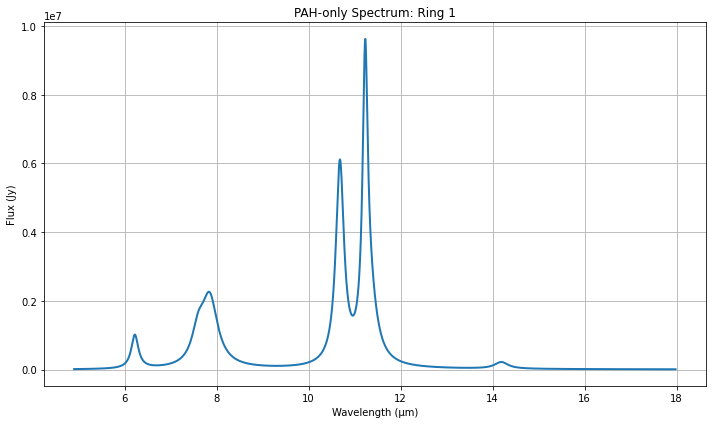

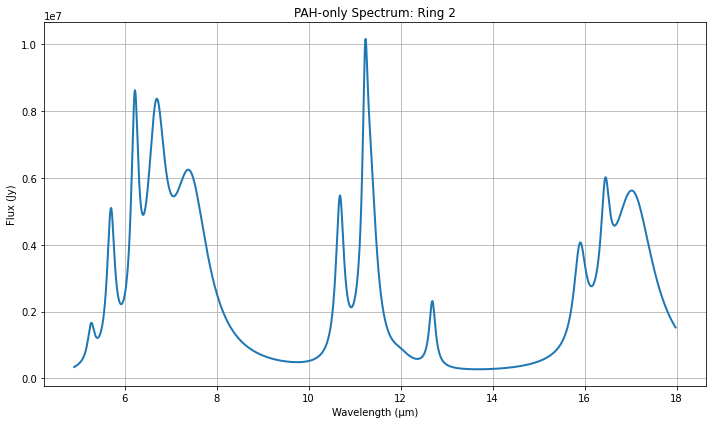

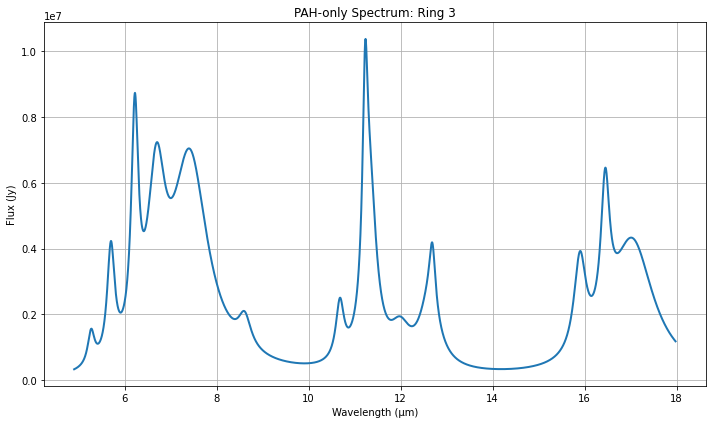

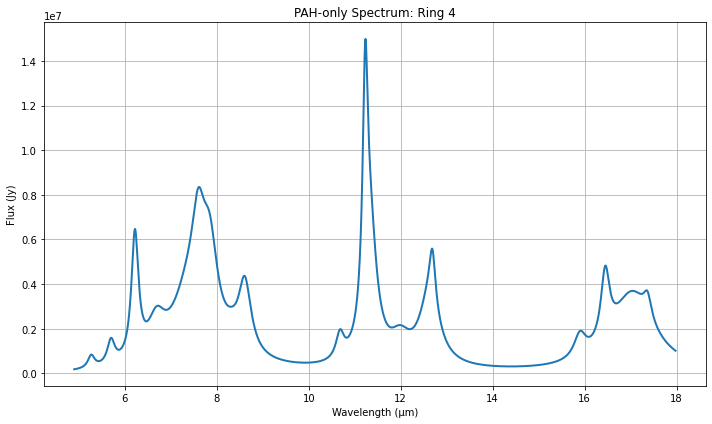

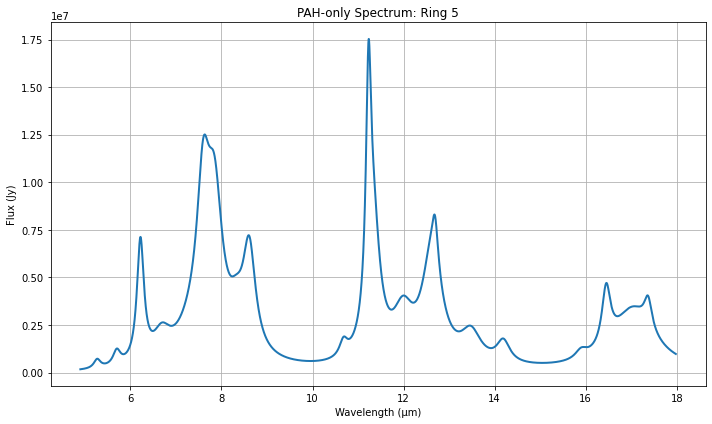

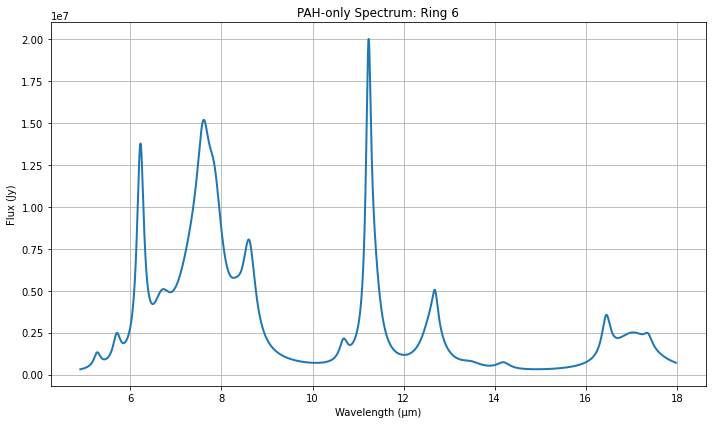

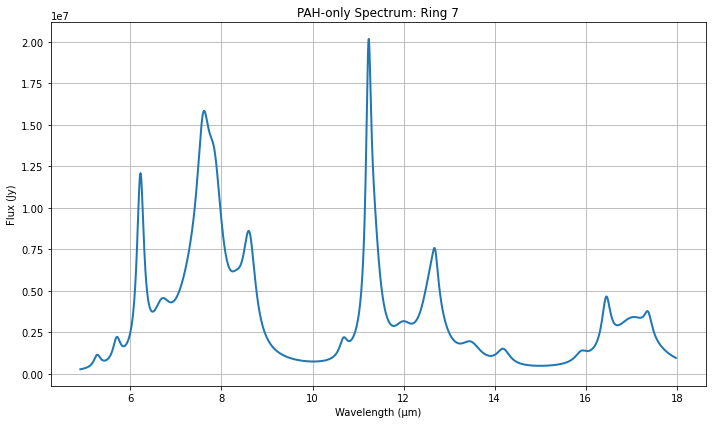

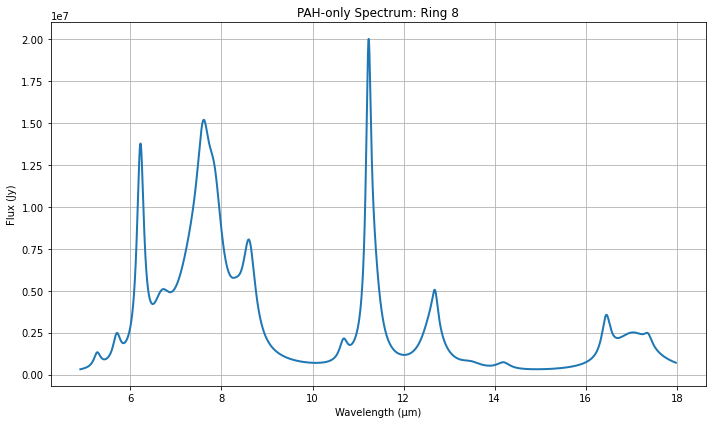

In [28]:
repo_dir = Path().resolve().parent
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

for i in range(1, 9):  # Change range if you have more/fewer rings
    fits_file = hydrocarbons_dir / f"Ring{i}_pahonly.fits"
    if not fits_file.exists():
        print(f"[SKIP] Not found: {fits_file.name}")
        continue

    table = Table.read(fits_file, hdu=1)
    wavelength = table['wavelength']
    flux = table['flux']

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux * 1e2, lw=2)  # Convert Jy to mJy
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Flux (Jy)')
    plt.title(f"PAH-only Spectrum: Ring {i}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
import numpy as np
from astropy.table import Table
from pathlib import Path

repo_dir = Path().resolve().parent
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

# Key PAH band centers (μm)
pah_centers = [6.2, 7.7, 8.6, 11.2, 12.7]
pah_labels = ['6.2', '7.7', '8.6', '11.2', '12.7']

def band_integral(wavelength, flux, center, width=0.2):
    mask = (wavelength > (center - width)) & (wavelength < (center + width))
    return np.trapz(flux[mask], wavelength[mask]) if np.any(mask) else np.nan

# Loop over rings and print results
for i in range(1, 9):
    fits_file = hydrocarbons_dir / f"Ring{i}_pahonly.fits"
    if not fits_file.exists():
        print(f"[SKIP] Not found: {fits_file.name}")
        continue

    table = Table.read(fits_file, hdu=1)
    wavelength = np.array(table['wavelength'])
    flux = np.array(table['flux'])

    band_fluxes = [band_integral(wavelength, flux, c) for c in pah_centers]

    # Diagnostic ratios
    ratio_112_77 = band_fluxes[3] / band_fluxes[1] if band_fluxes[1] else np.nan
    ratio_62_77  = band_fluxes[0] / band_fluxes[1] if band_fluxes[1] else np.nan
    ratio_86_77  = band_fluxes[2] / band_fluxes[1] if band_fluxes[1] else np.nan

    print(f"\n=== Ring {i} ===")
    for label, val in zip(pah_labels, band_fluxes):
        print(f"PAH {label} μm band strength: {val:.3g}")
    print(f"11.2/7.7: {ratio_112_77:.2f}   6.2/7.7: {ratio_62_77:.2f}   8.6/7.7: {ratio_86_77:.2f}")



=== Ring 1 ===
PAH 6.2 μm band strength: 2.22e+03
PAH 7.7 μm band strength: 7.57e+03
PAH 8.6 μm band strength: 847
PAH 11.2 μm band strength: 1.91e+04
PAH 12.7 μm band strength: 329
11.2/7.7: 2.53   6.2/7.7: 0.29   8.6/7.7: 0.11

=== Ring 2 ===
PAH 6.2 μm band strength: 2.23e+04
PAH 7.7 μm band strength: 1.8e+04
PAH 8.6 μm band strength: 4.14e+03
PAH 11.2 μm band strength: 2.5e+04
PAH 12.7 μm band strength: 5.17e+03
11.2/7.7: 1.39   6.2/7.7: 1.24   8.6/7.7: 0.23

=== Ring 3 ===
PAH 6.2 μm band strength: 2.21e+04
PAH 7.7 μm band strength: 2.06e+04
PAH 8.6 μm band strength: 7.42e+03
PAH 11.2 μm band strength: 2.49e+04
PAH 12.7 μm band strength: 1.17e+04
11.2/7.7: 1.21   6.2/7.7: 1.07   8.6/7.7: 0.36

=== Ring 4 ===
PAH 6.2 μm band strength: 1.53e+04
PAH 7.7 μm band strength: 3.07e+04
PAH 8.6 μm band strength: 1.43e+04
PAH 11.2 μm band strength: 3.35e+04
PAH 12.7 μm band strength: 1.59e+04
11.2/7.7: 1.09   6.2/7.7: 0.50   8.6/7.7: 0.46

=== Ring 5 ===
PAH 6.2 μm band strength: 1.64e+04
P

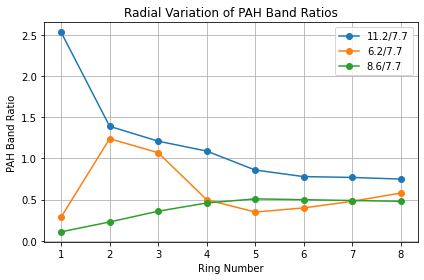

In [8]:
import matplotlib.pyplot as plt
rings = np.arange(1, 9)
ratios_112_77 = [2.53, 1.39, 1.21, 1.09, 0.86, 0.78, 0.77, 0.75]
ratios_62_77 =  [0.29, 1.24, 1.07, 0.50, 0.35, 0.40, 0.48, 0.58]
ratios_86_77 =  [0.11, 0.23, 0.36, 0.46, 0.51, 0.50, 0.49, 0.48]

plt.plot(rings, ratios_112_77, 'o-', label='11.2/7.7')
plt.plot(rings, ratios_62_77,  'o-', label='6.2/7.7')
plt.plot(rings, ratios_86_77,  'o-', label='8.6/7.7')
plt.xlabel('Ring Number')
plt.ylabel('PAH Band Ratio')
plt.title('Radial Variation of PAH Band Ratios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
from astropy.table import Table

i = 6  # Ring number you want to process

wavelength = np.array(spec.spectral_axis)
pah_only_flux = 0

# Loop over likely PAH indices ([9] to [32] in your printout)
for idx in range(9, 32):
    m = model.astropy_result[idx]
    if hasattr(m, 'name') and 'PAH' in m.name:
        print(f"Adding {m.name} to PAH-only spectrum.")
        pah_only_flux += m(wavelength)

# Save for PAHdb
pah_table = Table()
pah_table['wavelength'] = wavelength
pah_table['flux'] = pah_only_flux
pah_table.write(hydrocarbons_dir / f"Ring{i}_pahonly.fits", overwrite=True)
print(f"[PAHdb] Saved PAH-only spectrum: Ring{i}_pahonly.fits")


Adding PAH_5.3 to PAH-only spectrum.
Adding PAH_5.7 to PAH-only spectrum.
Adding PAH_6.2 to PAH-only spectrum.
Adding PAH_6.7 to PAH-only spectrum.
Adding PAH_7.7a to PAH-only spectrum.
Adding PAH_7.7b to PAH-only spectrum.
Adding PAH_7.7c to PAH-only spectrum.
Adding PAH_8.3 to PAH-only spectrum.
Adding PAH_8.6 to PAH-only spectrum.
Adding PAH_10.7 to PAH-only spectrum.
Adding PAH_11.3a to PAH-only spectrum.
Adding PAH_11.3b to PAH-only spectrum.
Adding PAH_12 to PAH-only spectrum.
Adding PAH_12.6a to PAH-only spectrum.
Adding PAH_12.6b to PAH-only spectrum.
Adding PAH_13.48 to PAH-only spectrum.
Adding PAH_14.04 to PAH-only spectrum.
Adding PAH_14.19 to PAH-only spectrum.
Adding PAH_15.9 to PAH-only spectrum.
Adding PAH_17a to PAH-only spectrum.
Adding PAH_17b to PAH-only spectrum.
Adding PAH_17c to PAH-only spectrum.
Adding PAH_17d to PAH-only spectrum.
[PAHdb] Saved PAH-only spectrum: Ring6_pahonly.fits


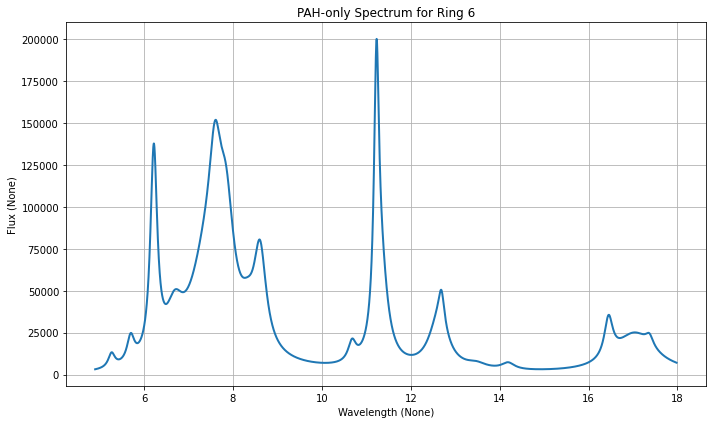

In [10]:
from astropy.table import Table
import matplotlib.pyplot as plt

i = 6  # <-- Set this to your ring number
fits_file = hydrocarbons_dir / f"Ring{i}_pahonly.fits"
table = Table.read(fits_file, hdu=1)

wavelength = table['wavelength']
flux = table['flux']

plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, color='tab:blue', lw=2)
plt.xlabel(f"Wavelength ({wavelength.unit})")
plt.ylabel(f"Flux ({flux.unit})")
plt.title(f"PAH-only Spectrum for Ring {i}")
plt.grid(True)
plt.tight_layout()
plt.show()


<div style="font-size:40px; color:#0F2080;">
  PAH<span style="color:#F5793A;">db
</div>

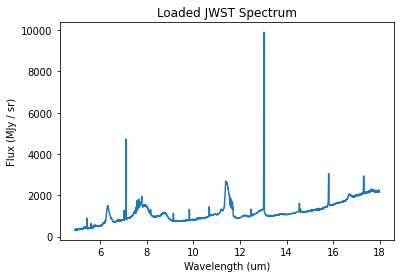

In [11]:
# Use same repo_dir and fits_dir as defined earlier
fits_file = fits_dir / "NGC7469__stitched.fits"

# Load with pyPAHdb Observation
obsjwst = Observation(str(fits_file))
obsjwst.spectrum.meta["colnames"] = ["Wavelength", "Flux"]
s = obsjwst.spectrum

# Plot
plt.plot(s.spectral_axis, s.flux[0, 0, :])
plt.xlabel(f"Wavelength ({s.spectral_axis.unit})")
plt.ylabel(f"Flux ({s.flux.unit})")
plt.title("Loaded JWST Spectrum")
plt.show()

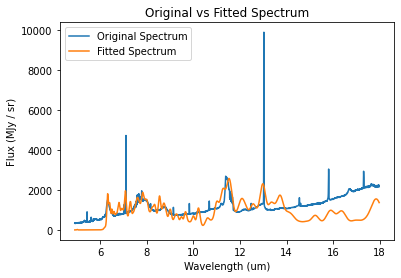

In [12]:
resultjwst = Decomposer(obsjwst.spectrum)

# Extract the fitted spectrum and plot
fitted_spectrum = resultjwst.fit
plt.plot(s.spectral_axis, s.flux[0, 0, :], label="Original Spectrum")
plt.plot(s.spectral_axis, fitted_spectrum[:, 0, 0], label="Fitted Spectrum")
plt.xlabel(f"Wavelength ({s.spectral_axis.unit})")
plt.ylabel(f"Flux ({s.flux.unit})")
plt.title("Original vs Fitted Spectrum")
plt.legend()
plt.show()

<div style="font-size:40px; color:#0F2080;">
  Getting the <span style="color:#F5793A;">residual
</div>

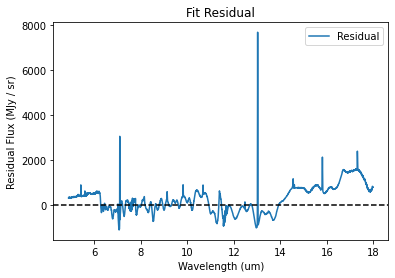

In [13]:
residual = s.flux[0, 0, :] - fitted_spectrum[:, 0, 0]
plt.plot(s.spectral_axis, residual, label="Residual")
plt.xlabel(f"Wavelength ({s.spectral_axis.unit})")
plt.ylabel(f"Residual Flux ({s.flux.unit})")
plt.title("Fit Residual")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.show()

<div style="font-size:40px; color:#0F2080;">
  Saving the  <span style="color:#F5793A;">results</span>
</div>

In [14]:
pdf_file = repo_dir / "1_Polycyclic" / "NGC7469.pdf"
fits_file = repo_dir / "3_Hydrocarbons" / "NGC7469_PAHdb.fits"

resultjwst.save_pdf(str(pdf_file))
resultjwst.save_fits(str(fits_file), header=obsjwst.header)

print(f"PDF saved to: {pdf_file}")
print(f"FITS saved to: {fits_file}")

PDF saved to: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\NGC7469.pdf
FITS saved to: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469_PAHdb.fits
